TIFF to zarr and maxprj

Objective: create a zarr file 
1. Find target files with a ".tif" extension.
2. Organize files in a directory by treatment.
3. Check the dictionary containing the file paths.
4. Create two numpy arrays per treatment: "raw" array containing all z-stacks for that treatment and "maxprj" containing the maxprj arrays for each treatment. Save them as zarr.
5. Check images in the zarr files


1. Find target files with a ".tif" extension

In [1]:
from imageio import imread
from pathlib import Path
import numpy as np
import zarr as zarr
import glob
import os

root_directory = "/mnt/efs/aimbl_2025/student_data/S-DD"
target_extension = ".tif"

#check if path exists
if not os.path.exists(root_directory):
    print(F"Error: directory '{root_directory}' does not exist")


#recursively find all TIFF files 
file_list = glob.glob(f"{root_directory}/**/*{target_extension}", recursive=True)
print(f"Found {len(file_list)} files with extension '{target_extension}'")




Found 950 files with extension '.tif'


2. Organize files in a dictionary by treatment

In [2]:
from tqdm import tqdm
# identify the treatments (as they are writen in the file name)
treatments = ("DMSO", "800nMActD", "8nMActD", "5uMflavo", "1uMdoxo", "10uMmg132", "10uMwort", "CX5461")

# create a dictionary to hold lists of files for each treatment
treatment_files = {treatment: [] for treatment in treatments}

#append files by treatment
for file in tqdm(file_list):
    filename = os.path.basename(file)
    for treatment in treatments:
        if treatment in filename:
            treatment_files[treatment].append(file)
            print(f"Added file '{filename}' to treatment '{treatment}'")

# print the number of files found for each treatment
for treatment, files in treatment_files.items():
    print(f"Treatment '{treatment}' has {len(files)} files.")


100%|██████████| 950/950 [00:00<00:00, 99136.39it/s]

Added file 'LD093-RPE1hTERT-DMSO-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m009_zcyx_stack.tif' to treatment 'DMSO'
Added file 'LD093-RPE1hTERT-CX5461-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m001_zcyx_stack.tif' to treatment 'CX5461'
Added file 'LD093-RPE1hTERT-DMSO-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m027_zcyx_stack.tif' to treatment 'DMSO'
Added file 'LD093-RPE1hTERT-CX5461-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m010_zcyx_stack.tif' to treatment 'CX5461'
Added file 'LD093-RPE1hTERT-DMSO-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m018_zcyx_stack.tif' to treatment 'DMSO'
Added file 'LD093-RPE1hTERT-10uMwort-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m014_zcyx_stack.tif' to treatment '10uMwort'
Added file 'LD093-RPE1hTERT-5uMflavo-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m023_zcyx_stack.tif' to treatment '5uMflavo'
Added file 'LD093-RPE1hTERT-8nMActD-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m023_zcyx_stack.tif' to treatment '8nMActD'
Added file 'LD093-RPE1hTERT-800nMActD-DAPI-A488FBL-A568UBF-40X-15Z-Leica_m023_zcyx_stack.tif' to t

3. Check the dictionary containing the file paths

In [3]:
print(f"treatment_files dictionary keys: {list(treatment_files.keys())}")
for treatment in treatment_files.keys():
    print(f"There are {len(treatment_files[treatment])} files for treatment: {treatment}")

treatment_files dictionary keys: ['DMSO', '800nMActD', '8nMActD', '5uMflavo', '1uMdoxo', '10uMmg132', '10uMwort', 'CX5461']
There are 115 files for treatment: DMSO
There are 145 files for treatment: 800nMActD
There are 115 files for treatment: 8nMActD
There are 115 files for treatment: 5uMflavo
There are 115 files for treatment: 1uMdoxo
There are 115 files for treatment: 10uMmg132
There are 115 files for treatment: 10uMwort
There are 115 files for treatment: CX5461


4. Create two numpy arrays per treatment: "raw" array containing all z-stacks for that treatment and "maxprj" containing the maxprj arrays for each treatment. Save them as zarr.

In [4]:
z= zarr.open("/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", mode="w")
for treatment in treatment_files.keys():
    print(f"Processing treatment: {treatment}")
    file_paths = treatment_files[treatment]
    if not file_paths:
        print(f"No files found for treatment: {treatment}, skipping.")
        continue
    
    # Read the first image to get the shape
    sample_image = imread(file_paths[0])
    image_shape = sample_image.shape
    num_images = len(file_paths)
    print(f"Each image has shape {image_shape}, total images: {num_images}")
    # Create a numpy array for this treatment
    treatment_stack_array = np.zeros((num_images, *image_shape), dtype=sample_image.dtype)
    treatment_maxprj_array = np.zeros((num_images, image_shape[1], image_shape[2], image_shape[3]), dtype=sample_image.dtype)  # Max projection shape is (512, 512)

    # Load images into the numpy array
    for i, file_path in enumerate(tqdm(file_paths, desc=f"Loading images for {treatment}")):
        image = imread(file_path)
        treatment_stack_array[i] = image
        treatment_maxprj_array[i] = np.max(image, axis=0)
    print(f"Created array for treatment '{treatment}' with shape {treatment_stack_array.shape}")
    print(f"Created max projection array for treatment '{treatment}' with shape {treatment_maxprj_array.shape}")

    # Save the numpy array to the zarr file
    zarr.create_array(store="/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", name=f"{treatment}/raw", data= treatment_stack_array, chunks=(1, *image_shape))
    zarr.create_array(store="/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", name=f"{treatment}/max", data= treatment_maxprj_array, chunks=(num_images, *image_shape[1:]))


/tmp/ipykernel_559376/1521174640.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sample_image = imread(file_paths[0])


Processing treatment: DMSO
Each image has shape (15, 3, 512, 512), total images: 115


Loading images for DMSO:   0%|          | 0/115 [00:00<?, ?it/s]/tmp/ipykernel_559376/1521174640.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path)
Loading images for DMSO: 100%|██████████| 115/115 [00:08<00:00, 12.93it/s]


Created array for treatment 'DMSO' with shape (115, 15, 3, 512, 512)
Created max projection array for treatment 'DMSO' with shape (115, 3, 512, 512)
Processing treatment: 800nMActD
Each image has shape (15, 3, 512, 512), total images: 145


Loading images for 800nMActD: 100%|██████████| 145/145 [00:10<00:00, 13.54it/s]


Created array for treatment '800nMActD' with shape (145, 15, 3, 512, 512)
Created max projection array for treatment '800nMActD' with shape (145, 3, 512, 512)
Processing treatment: 8nMActD
Each image has shape (15, 3, 512, 512), total images: 115


Loading images for 8nMActD: 100%|██████████| 115/115 [00:08<00:00, 14.09it/s]


Created array for treatment '8nMActD' with shape (115, 15, 3, 512, 512)
Created max projection array for treatment '8nMActD' with shape (115, 3, 512, 512)
Processing treatment: 5uMflavo
Each image has shape (15, 3, 512, 512), total images: 115


Loading images for 5uMflavo: 100%|██████████| 115/115 [00:06<00:00, 18.47it/s]


Created array for treatment '5uMflavo' with shape (115, 15, 3, 512, 512)
Created max projection array for treatment '5uMflavo' with shape (115, 3, 512, 512)
Processing treatment: 1uMdoxo
Each image has shape (15, 3, 512, 512), total images: 115


Loading images for 1uMdoxo: 100%|██████████| 115/115 [00:05<00:00, 20.93it/s]


Created array for treatment '1uMdoxo' with shape (115, 15, 3, 512, 512)
Created max projection array for treatment '1uMdoxo' with shape (115, 3, 512, 512)
Processing treatment: 10uMmg132
Each image has shape (15, 3, 512, 512), total images: 115


Loading images for 10uMmg132: 100%|██████████| 115/115 [00:04<00:00, 28.75it/s]


Created array for treatment '10uMmg132' with shape (115, 15, 3, 512, 512)
Created max projection array for treatment '10uMmg132' with shape (115, 3, 512, 512)
Processing treatment: 10uMwort
Each image has shape (15, 3, 512, 512), total images: 115


Loading images for 10uMwort: 100%|██████████| 115/115 [00:04<00:00, 26.70it/s]


Created array for treatment '10uMwort' with shape (115, 15, 3, 512, 512)
Created max projection array for treatment '10uMwort' with shape (115, 3, 512, 512)
Processing treatment: CX5461
Each image has shape (15, 3, 512, 512), total images: 115


Loading images for CX5461: 100%|██████████| 115/115 [00:03<00:00, 29.11it/s]


Created array for treatment 'CX5461' with shape (115, 15, 3, 512, 512)
Created max projection array for treatment 'CX5461' with shape (115, 3, 512, 512)


5. Check images in the stack array file using matplotlib.pyplot

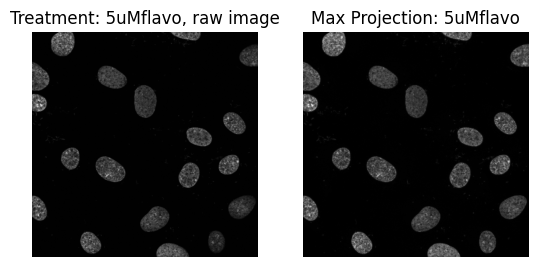

In [5]:
import matplotlib.pyplot as plt

#open zarr file in read mode
z = zarr.open("/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", mode="r")

#visualize an image
treatment = "5uMflavo"
# Select a z-stack and perform max projection over the channel axis
image_from_stack = z[treatment]["raw"][0][7][0]  # shape: (512, 512)
maxproj_image = z[treatment]["max"][0][0]        # shape: (512, 512)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(image_from_stack, cmap="gray")
axes[0].set_title(f"Treatment: {treatment}, raw image")
axes[0].axis("off")
axes[1].imshow(maxproj_image, cmap="gray")
axes[1].set_title(f"Max Projection: {treatment}")
axes[1].axis("off")
plt.show()

5. Check images in the zarr file using napari

In [6]:
import napari
import zarr
#open zarr file in read mode
z = zarr.open("/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", mode="r")
# define treatment
treatment="DMSO"
z_stack=z[treatment]["raw"]
max= z[treatment]["max"][0][0]
mask = z[treatment]["masks"][0]
viewer = napari.Viewer()
image_layer = viewer.add_image(max, name=f"{treatment} maxproj", colormap="gray")
label_layer = viewer.add_labels(mask, name='segmentation')

